## Importing the required libraries

In [1]:
# library required for structured Python code
%load_ext nb_black

# library required to suppress any warning messages
import warnings

warnings.filterwarnings("ignore")

# library required for data analysis and visualization
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set(color_codes=True)  # adds background to the graph
from wordcloud import WordCloud

# to suppress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# libraries required for text pre-processing and stemming
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import contractions

# libraries required for text representations
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# libraries required for model building and hyperparameter tuning of models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# libraries required for model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score, f1_score

<IPython.core.display.Javascript object>

## Load Dataset

In [2]:
# reading the dataset as a dataframe
data = pd.read_csv("Train_Dataset.csv")

# making a copy of the dataset
df = data.copy()

<IPython.core.display.Javascript object>

## Data Structure Analysis

In [3]:
# viewing top 10 observations from the dataset
df.head(10)

,headline,is_sarcastic
0,supreme court votes 7-2 to legalize all worldl...,1
1,hungover man horrified to learn he made dozens...,1
2,emily's list founder: women are the 'problem s...,0
3,send your kids back to school with confidence,0
4,watch: experts talk pesticides and health,0
5,james corden and the red hot chili peppers str...,0
6,u.s. dignity reserves nearly depleted,1
7,"how to re-ignite the spark in your body, mind ...",0
8,report: there still time to convert to christi...,1
9,education reform and evidence,0


<IPython.core.display.Javascript object>

In [4]:
# checking the shape of the dataset
df.shape

(44262, 2)

<IPython.core.display.Javascript object>

- There are 44262 rows and 2 columns in the dataset 

In [5]:
# checking the overall information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44262 entries, 0 to 44261
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      44262 non-null  object
 1   is_sarcastic  44262 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 691.7+ KB


<IPython.core.display.Javascript object>

- Two columns one of each 'object' and 'int' datatype
- No missing values. Will double check the same.

In [6]:
# checking for missing values
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

<IPython.core.display.Javascript object>

- No missing values in the dataset

In [7]:
# checking for duplicate values
df.duplicated().sum()

17204

<IPython.core.display.Javascript object>

- 17204 rows of duplicated rows in the dataset

In [8]:
# removing duplicate values
df.drop_duplicates(inplace=True)  # deops duplicates except for the first occurence

<IPython.core.display.Javascript object>

In [9]:
# checking the shape of the dataset
df.shape

(27058, 2)

<IPython.core.display.Javascript object>

- The dataset now contains 27058 rows

In [10]:
# checking for the number of unique values after removing the duplicates
df.nunique()

headline        27058
is_sarcastic        2
dtype: int64

<IPython.core.display.Javascript object>

In [11]:
# distribution of labels in the target varibale
df["is_sarcastic"].value_counts()

0    14358
1    12700
Name: is_sarcastic, dtype: int64

<IPython.core.display.Javascript object>

- The target labels are quite balanced.

## Text Pre-processing

In [12]:
# remove some stopwords to capture negation in n-grams if possible
stop_words = stopwords.words("english")

# load a simple porter stemmer
ps = PorterStemmer()


def simple_text_preprocessor(document):
    """ Perform basic text pre-processing tasks """

    # remove unnecessary characters
    document = re.sub(r"[^a-zA-Z\s]", "", document, re.I | re.A)
    document = re.sub(r"\[[0-9]*\]", " ", document)
    document = re.sub(" +", " ", document)

    # lower case
    document = str(document).lower()

    # remove trailing whitespaces
    document = document.strip()

    # expand contractions
    document = contractions.fix(document)

    # simple porter stemming
    document = " ".join([ps.stem(word) for word in document.split()])

    # tokenize document
    tokens = nltk.word_tokenize(document)

    # stopwords removal
    document = " ".join([word for word in document.split() if word not in stop_words])

    return document


# vectorize function
stp = np.vectorize(simple_text_preprocessor)

<IPython.core.display.Javascript object>

In [13]:
# creating a new column with cleaned text
df["clean_headline"] = stp(df["headline"].values)
df.head()

,headline,is_sarcastic,clean_headline
0,supreme court votes 7-2 to legalize all worldl...,1,suprem court vote legal worldli vice
1,hungover man horrified to learn he made dozens...,1,hungov man horrifi learn made dozen plan last ...
2,emily's list founder: women are the 'problem s...,0,emili list founder women problem solver congress
3,send your kids back to school with confidence,0,send kid back school confid
4,watch: experts talk pesticides and health,0,watch expert talk pesticid health


<IPython.core.display.Javascript object>

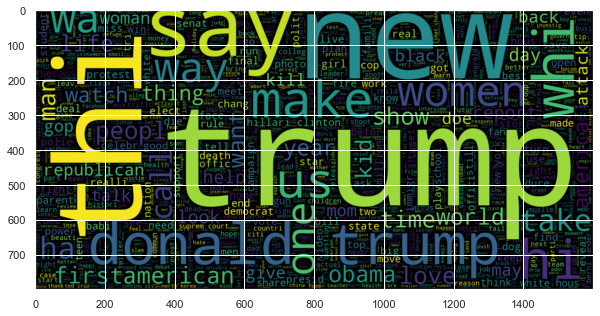

<IPython.core.display.Javascript object>

In [14]:
# plotting a word cloud for non-sarcastic headline
plt.figure(figsize=(10, 12))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(
    " ".join(df[df.is_sarcastic == 0].clean_headline)
)
plt.imshow(wc, interpolation="bilinear")

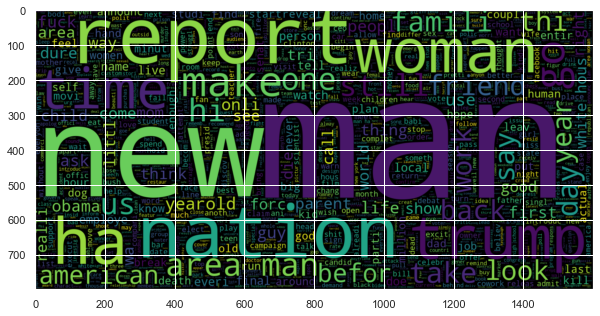

<IPython.core.display.Javascript object>

In [15]:
# plotting a word cloud for sarcastic headline
plt.figure(figsize=(10, 12))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(
    " ".join(df[df.is_sarcastic == 1].clean_headline)
)
plt.imshow(wc, interpolation="bilinear")

## Splitting Data

In [16]:
# separating dependent and independent variables
X = df.drop(["headline", "is_sarcastic"], axis=1)
y = df["is_sarcastic"]

<IPython.core.display.Javascript object>

In [17]:
# split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# checking shape of train and test datasets
print("Number of rows in train data:", X_train.shape[0])
print("Number of rows in test data:", X_test.shape[0])

# distribution of target labels in train and test data
print("\nDistribution of labels:")
print(
    "\nTrain data: Label 1 = {} | Label 0 = {}".format(
        sum(y_train == 1), sum(y_train == 0)
    ),
)
print(
    "Test data: Label 1 = {} | Label 0 = {}".format(sum(y_test == 1), sum(y_test == 0))
)

Number of rows in train data: 21646
Number of rows in test data: 5412

Distribution of labels:

Train data: Label 1 = 10160 | Label 0 = 11486
Test data: Label 1 = 2540 | Label 0 = 2872


<IPython.core.display.Javascript object>

In [18]:
print("Percentage of classes in training set :")
print(y_train.value_counts(normalize=True))

print("\nPerentage of classes in test set :")
print(y_test.value_counts(normalize=True))

Percentage of classes in training set :
0   0.531
1   0.469
Name: is_sarcastic, dtype: float64

Perentage of classes in test set :
0   0.531
1   0.469
Name: is_sarcastic, dtype: float64


<IPython.core.display.Javascript object>

- The distribution of target lables is balanced in both train and test data sets

In [19]:
# checking the first 5 rows of train dataset
X_train.head()

,clean_headline
10531,trump explan remov sudan hi travel ban cringew...
3304,mom demand action everytown flex grassroot mus...
2733,suprem court understudi fill scalia
1077,phil spector join jennif hudson present best n...
33712,suicid attack methodist church pakistan kill n...


<IPython.core.display.Javascript object>

## Model Building

I will be building Logistic Regression model with below feature engineering techniques for NLP text representation:

- Bag of N-Grams Model and
- TF-IDF Model

Then hyperparameter tune the model with better metric scores.

## Bag of N-Grams Model

In [20]:
# instantiate count vectorizer
cv = CountVectorizer(ngram_range=(2, 2))

# cv fit and transform on train data
X_traincv = cv.fit_transform(X_train["clean_headline"]).toarray()
X_traincv = pd.DataFrame(X_traincv, columns=cv.get_feature_names())

# cv transform on test data
X_testcv = cv.transform(X_test["clean_headline"]).toarray()
X_testcv = pd.DataFrame(X_testcv, columns=cv.get_feature_names())

X_traincv.head()

,aaa member,aaron carter,aaron eckhart,aaron hernandez,aaron rodger,aarp blast,aarp call,aarp repres,aarp want,aarp warn,...,zuckerberg promis,zuckerberg reallif,zuckerberg recal,zuckerberg regret,zuckerberg sell,zuckerberg senat,zuckerberg tout,zuckerberg trump,zuckerberg watch,zuckerberg wish
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [21]:
# build log model
lr_cv = LogisticRegression(random_state=1, solver="liblinear")

# train model
lr_cv.fit(X_traincv, y_train)

LogisticRegression(random_state=1, solver='liblinear')

<IPython.core.display.Javascript object>

In [22]:
# predict on test data
lr_cv_predictions = lr_cv.predict(X_testcv)

# evaluate model
print(classification_report(y_test, lr_cv_predictions))

              precision    recall  f1-score   support

           0       0.63      0.91      0.74      2872
           1       0.80      0.40      0.53      2540

    accuracy                           0.67      5412
   macro avg       0.71      0.65      0.64      5412
weighted avg       0.71      0.67      0.64      5412



<IPython.core.display.Javascript object>

Text(0.5, 12.5, 'Predicted label')

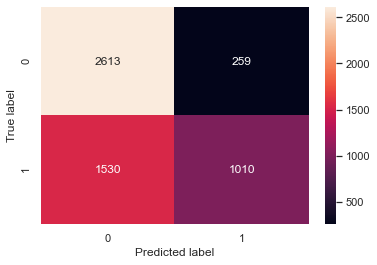

<IPython.core.display.Javascript object>

In [23]:
cm = metrics.confusion_matrix(y_test, lr_cv_predictions)
cm = pd.DataFrame(cm, index=["0", "1"], columns=["0", "1"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="")
plt.ylabel("True label")
plt.xlabel("Predicted label")

- The model is able to predict 91% of the total number of non-sarcastic headlines whereas only 40% of the sarcastic ones.

- The F1-score for the sarcastic headlines is also low comparatively.

- The accuracy is only 67% with an overall F1-score of 64%.

Will see if the scores gets improved with TF-IDF model.

## TF-IDF Model

In [24]:
# instantiate tfidfvectorizer
tfidf = TfidfVectorizer(min_df=0.0, max_df=1.0, use_idf=True)

# tfidf fit and transform on train data
X_traintfidf = tfidf.fit_transform(X_train["clean_headline"]).toarray()
X_traintfidf = pd.DataFrame(X_traintfidf, columns=tfidf.get_feature_names())

# tfidf transform on test data
X_testtfidf = tfidf.transform(X_test["clean_headline"]).toarray()
X_testtfidf = pd.DataFrame(X_testtfidf, columns=tfidf.get_feature_names())
X_traintfidf.head()

,aaa,aaron,aarp,aatish,ab,abandon,abaya,abba,abbey,abbi,...,zoo,zookeep,zooland,zoologist,zoom,zoroastrian,zs,zsa,zucker,zuckerberg
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


<IPython.core.display.Javascript object>

In [25]:
# build log model
lr_tfidf = LogisticRegression(random_state=1, solver="liblinear")

# train model
lr_tfidf.fit(X_traintfidf, y_train)

LogisticRegression(random_state=1, solver='liblinear')

<IPython.core.display.Javascript object>

In [26]:
# predict on test data
lr_tfidf_predictions = lr_tfidf.predict(X_testtfidf)

# evaluate model
print(classification_report(y_test, lr_tfidf_predictions))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81      2872
           1       0.80      0.74      0.77      2540

    accuracy                           0.79      5412
   macro avg       0.79      0.79      0.79      5412
weighted avg       0.79      0.79      0.79      5412



<IPython.core.display.Javascript object>

Text(0.5, 12.5, 'Predicted label')

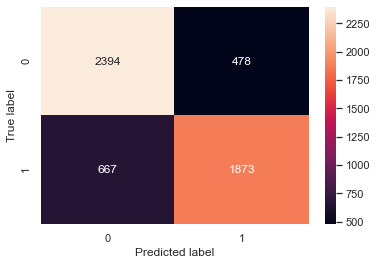

<IPython.core.display.Javascript object>

In [27]:
cm = metrics.confusion_matrix(y_test, lr_tfidf_predictions)
cm = pd.DataFrame(cm, index=["0", "1"], columns=["0", "1"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="")
plt.ylabel("True label")
plt.xlabel("Predicted label")

- The model is able to predict 81% of the total number of non-sarcastic headlines and 77%% of the sarcastic ones which is better than the previous model.

- The F1-score for the target labels are quite balanced.

- The accuracy and F1-score have both improved to 79%.

- The TF-IDF model performs much better than the N-grams model. Hence will hyperparameter tune this model to achieve better results.

## Hyper-parameter Tuning 

### Randomized SearchCV

In [28]:
# choose classifier
lr_tuned = LogisticRegression(random_state=1, solver="liblinear")

# Parameter grid to pass in GridSearchCV
parameters = {"C": np.arange(0.1, 1.1, 0.1), "penalty": ["l1", "l2"]}

# Type of scoring used to compare parameter combinations
scorer = {"accuracy": make_scorer(accuracy_score), "f1-score": make_scorer(f1_score)}

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=lr_tuned,
    param_distributions=parameters,
    n_jobs=-1,
    n_iter=50,
    scoring=scorer,
    cv=5,
    refit="accuracy",
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_traintfidf, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(random_state=1,
                                                solver='liblinear'),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'penalty': ['l1', 'l2']},
                   random_state=1, refit='accuracy',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'f1-score': make_scorer(f1_score)})

<IPython.core.display.Javascript object>

In [29]:
print(
    "Best parameters are {} with CV score : {} ".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'penalty': 'l2', 'C': 1.0} with CV score : 0.780513354000652 


<IPython.core.display.Javascript object>

### GridSearchCV

In [30]:
# choose classifier
lr_tuned = LogisticRegression(random_state=1, solver="liblinear")

# grid of parameters to choose from
params = {"C": np.arange(0.5, 1.5, 0.1), "penalty": ["l2"]}

# Type of scoring used to compare parameter combinations
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1-score": make_scorer(f1_score),
}

# run the grid search
grid_obj = GridSearchCV(
    lr_tuned, params, scoring=scoring, cv=5, refit="accuracy", n_jobs=-1
)
grid_obj = grid_obj.fit(X_traintfidf, y_train)

# set the classifier to the best combination of parameters
lr_tuned = grid_obj.best_estimator_

# fit the best algorithm to the data
lr_tuned.fit(X_traintfidf, y_train)

LogisticRegression(C=1.4, random_state=1, solver='liblinear')

<IPython.core.display.Javascript object>

In [31]:
# predict on test data
lr_tuned_predictions = lr_tuned.predict(X_testtfidf)

# evaluate model
print(classification_report(y_test, lr_tuned_predictions))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      2872
           1       0.79      0.74      0.77      2540

    accuracy                           0.79      5412
   macro avg       0.79      0.79      0.79      5412
weighted avg       0.79      0.79      0.79      5412



<IPython.core.display.Javascript object>

Text(0.5, 12.5, 'Predicted label')

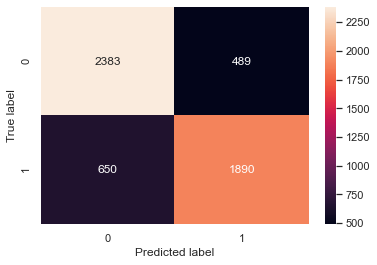

<IPython.core.display.Javascript object>

In [32]:
cm = metrics.confusion_matrix(y_test, lr_tuned_predictions)
cm = pd.DataFrame(cm, index=["0", "1"], columns=["0", "1"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="")
plt.ylabel("True label")
plt.xlabel("Predicted label")

- All the metric scores are well balanced in the hyperparameter tuned model. Will use this model to make predictions on the unseen test data

## Conclusion

- I have built a very basic Logistic Regression model by comparing Bag of N-grams and TF-IDF models. Could as well try different algorithms like Support Vector Machines, XgBoost, Ensemble models, etc.
- Could as well try Word Embedding methods like Word2Vec and GloVe for better performance

## Submission

In [33]:
# reading the unseen test dataset as dataframe
test_data = pd.read_csv("Test_Dataset.csv")

<IPython.core.display.Javascript object>

In [34]:
# checking the shape of the dataset
test_data.shape

(11066, 1)

<IPython.core.display.Javascript object>

- Test dataset consists of 11066 rows

In [35]:
# viewing the top 5 rows
test_data.head()

,headline
0,area stand-up comedian questions the deal with...
1,dozens of glowing exit signs mercilessly taunt...
2,perfect response to heckler somewhere in prop ...
3,gop prays for ossoff lossoff
4,trevor noah says the scary truth about trump's...


<IPython.core.display.Javascript object>

In [36]:
# performing simple_text_processor on test_date and creating a new column with the cleaned text
test_data["clean_headline"] = stp(test_data["headline"].values)
test_data.head()

,headline,clean_headline
0,area stand-up comedian questions the deal with...,area standup comedian question deal drivethru ...
1,dozens of glowing exit signs mercilessly taunt...,dozen glow exit sign mercilessli taunt multipl...
2,perfect response to heckler somewhere in prop ...,perfect respons heckler somewher prop comedian...
3,gop prays for ossoff lossoff,gop pray ossoff lossoff
4,trevor noah says the scary truth about trump's...,trevor noah say scari truth trump rumor love c...


<IPython.core.display.Javascript object>

In [37]:
# tfidf transform on test data
test_data_tfidf = tfidf.transform(test_data["clean_headline"]).toarray()
test_data_tfidf = pd.DataFrame(test_data_tfidf, columns=tfidf.get_feature_names())
test_data_tfidf.head()

,aaa,aaron,aarp,aatish,ab,abandon,abaya,abba,abbey,abbi,...,zoo,zookeep,zooland,zoologist,zoom,zoroastrian,zs,zsa,zucker,zuckerberg
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


<IPython.core.display.Javascript object>

In [38]:
# making predictions on the unseen data
pred = lr_tuned.predict(test_data_tfidf)

# saving the predictions to a dataframe
submission = pd.DataFrame()

# with column name 'prediction'
submission["prediction"] = pred
submission.head()

,prediction
0,1
1,1
2,1
3,0
4,0


<IPython.core.display.Javascript object>

In [39]:
# checking the shape of the submission file
submission.shape

(11066, 1)

<IPython.core.display.Javascript object>

- The number of rows in the submission file matches with test_data. Hence, ready for submission.

In [40]:
# saving the predictions to a csv file for submission
submission.to_csv("Test_Data_Predictions.csv", index=False)

<IPython.core.display.Javascript object>